# Data Synthesis and Data cleaning
### Import the data from the video with the time and the number of measurements per frame

In [39]:
#Load the pickle file containing the list of FrameInfo objects
import pickle
#Don't forget to execute the FrameInfo class definition before importing the pickle file

In [40]:
class FrameInfo:
    def __init__(self, frame_number, time_in_milliseconds, measCount, measLowIndex, HighIndex):
        self.frame_number = frame_number
        self.time_in_milliseconds = time_in_milliseconds
        self.measCount=measCount
        self.measLowIndex=measLowIndex
        self.HighIndex=HighIndex
    
    def __repr__(self):
        return f"Frame {self.frame_number} at {self.time_in_milliseconds} ms with {self.measCount} measurements at index {self.measLowIndex} to {self.HighIndex}"
    
    def getNbMeas(self):
        return self.measCount
    def getMeasIndex(self):
        return (self.measLowIndex, self.HighIndex)

In [41]:

# Load the list of frames and there respectives infos from the file
with open('F:/Data_BachelorHES/Video_CNC/frameData.pkl', 'rb') as f:
    frameData = pickle.load(f)
del f

The frameData list contains FrameInfo objects with the following attributes:
- frame_number: the frame number in the video
- time_in_milliseconds: the time in milliseconds of the frame
- measCount: the number of measurements in the frame
- measLowIndex: the index of the first measurement in the array of measurements
- HighIndex: the index of the last measurement in the array of measurements
An example of one FrameInfo object representation is shown below:

In [42]:
print(frameData[0])

Frame 9965 at 332245.60000000003 ms with 8335 measurements at index 32107536 to 32115871


# Import the data from the video with the recognized labels

In [43]:
#Import recognized labels from the video 
import pandas as pd
DfImportParquet=pd.read_parquet('F:/Data_BachelorHES/3.Video_CNC/10.ProcessingResults/OCR_Program_Match_LabelledData.parquet', engine='pyarrow')
    

# Import the data from the .csv files with the sound and the accelerations

In [44]:
#Define the path to the .csv files
soundPath='F:/Data_BachelorHES/2.extracted_measurements/sound.csv'
accelXPath='F:/Data_BachelorHES/2.extracted_measurements/accelX.csv'
accelYPath='F:/Data_BachelorHES/2.extracted_measurements/accelY.csv'
accelZPath='F:/Data_BachelorHES/2.extracted_measurements/accelZ.csv'

In [45]:
#Import the measurements from the .csv files
import pandas as pd
import array
sound = pd.read_csv(soundPath, header=None, names=['values'])
accelX = pd.read_csv(accelXPath, header=None, names=['values'])
accelY = pd.read_csv(accelYPath, header=None, names=['values'])
accelZ = pd.read_csv(accelZPath, header=None, names=['values'])
print(sound.shape, accelX.shape, accelY.shape, accelZ.shape)

sound_array = array.array('h', sound.values.flatten().astype(int))  # 'h' pour int16 (2 octets par valeur)
accelX_array=array.array('h', accelX.values.flatten().astype(int))
accelY_array=array.array('h', accelY.values.flatten().astype(int))
accelZ_array=array.array('h', accelZ.values.flatten().astype(int))

del sound, accelX, accelY, accelZ, accelXPath, accelYPath, accelZPath, soundPath

(495000000, 1) (495000000, 1) (495000000, 1) (495000000, 1)


# Create a dictionary with the data and convert it to a pandas dataframe with all the data

In [46]:
myDataStreams= {'frame': [], 
                'frame_time_ms': [], 
                'frame_duration_ms': [], 
                'Data_points': [], 
                "Sound": [],
                "Accel X": [], 
                "Accel Y": [], 
                "Accel Z": [], 
                'Label_Program_Line': [], 
                'Label_Op_Name': [],
                'Label_Tool_Name': []}

for i, frame in enumerate(frameData):
    myDataStreams['frame'].append(frameData[i].frame_number)
    myDataStreams['frame_time_ms'].append(frameData[i].time_in_milliseconds)
    myDataStreams['frame_duration_ms'].append(frameData[i].measCount/50)
    myDataStreams['Data_points'].append(frameData[i].measCount)
    myDataStreams["Sound"].append(sound_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams["Accel X"].append(accelX_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams["Accel Y"].append(accelY_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams["Accel Z"].append(accelZ_array[frameData[i].measLowIndex:frameData[i].HighIndex].tolist())
    myDataStreams['Label_Program_Line'].append(DfImportParquet['Line_Text_Program'][i])
    myDataStreams['Label_Op_Name'].append(DfImportParquet['Op_Name'][i])
    myDataStreams['Label_Tool_Name'].append(DfImportParquet['Tool_Name'][i])


myDf=pd.DataFrame.from_dict(myDataStreams)

In [47]:
import pyarrow as pa 
import pyarrow.parquet as pq

myDataset=pa.Table.from_pandas(myDf)
pq.write_table(myDataset, 'F:/Data_BachelorHES/5.Dataset_preparation/CNC_Labelled_Data.parquet')
del myDataset

In [49]:
del accelX_array, accelY_array, accelZ_array, sound_array, myDataStreams, frameData, frame, DfImportParquet

### Export of a selection of frames for relabelling

In [ ]:
import os
import shutil
src_root='F:/Data_BachelorHES/3.Video_CNC/8.FullyProcessedOCR/kaggle_Images'
dest_folder='F:/Data_BachelorHES/5.Dataset_preparation/subImages'
# Assure que le dossier cible existe
os.makedirs(dest_folder, exist_ok=True)

for subdir in os.listdir(src_root):
   intsubdir=int(subdir) 
   subdirPath=os.path.join(src_root, subdir)
   if 116210<=intsubdir<=122980:
       if os.path.isdir(subdirPath):
           for f in os.listdir(subdirPath):
               
               if f=='ocr_image.png':
                   srcImg=os.path.join(subdirPath, f)
                   destImg=os.path.join(dest_folder, f"{subdir}.png")
                   shutil.copy(srcImg, destImg)
   if intsubdir>122980:
       break

In [ ]:
del dest_folder, src_root,  subdir, intsubdir, subdirPath, f,  srcImg, destImg

In [ ]:
myLabelsPath='F:/Data_BachelorHES//5.Dataset_preparation/subImages/subLabels.csv'
myLabels=pd.read_csv(myLabelsPath, sep=';', header=None)
myLabels.columns=['frame', 'Label_Program_Line', 'Label_Op_Name', 'Label_Tool_Name']
del myLabelsPath

In [ ]:
DfLabelledTimeSeries=pd.read_parquet('F:/Data_BachelorHES/5.Dataset_preparation/CNC_Labelled_Data.parquet', engine='pyarrow')

DfLabelledTimeSeries.loc[DfLabelledTimeSeries['frame'].isin(myLabels['frame']), ['Label_Program_Line', 'Label_Op_Name', 'Label_Tool_Name']]=myLabels[['Label_Program_Line', 'Label_Op_Name', 'Label_Tool_Name']].values

In [ ]:
import pyarrow as pa 
import pyarrow.parquet as pq
path='F:/Data_BachelorHES/CNC_Labelled_Data_Corrected.parquet'
myResTable=pa.Table.from_pandas(DfLabelledTimeSeries)
pq.write_table(myResTable, path)
del myResTable, path

# Analysis of raw labels
## Extracting each program line number from the label and plotting the evolution of the program line number with respect to the frame numbers

In [2]:
import pandas as pd
import pyarrow as pa 
import pyarrow.parquet as pq

DfLabelledTimeSeries=pd.read_parquet('F:/Data_BachelorHES/5.Dataset_preparation/CNC_Labelled_Data_Corrected.parquet', engine='pyarrow')

In [3]:
myIndices=[]
for index, row in DfLabelledTimeSeries.iterrows():
    progNum=int(row['Label_Program_Line'].split()[0][1:])
    myIndices.append(progNum)
myIndicesPd=pd.Series(myIndices)
del index, row, progNum, myIndices

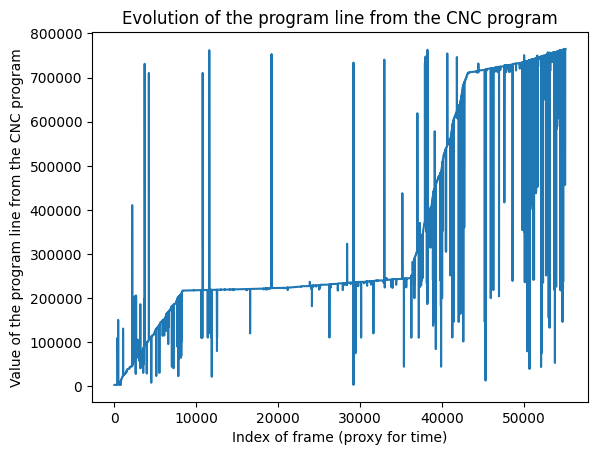

In [5]:
import numpy as np
import matplotlib.pyplot  as plt

x=np.arange(len(myIndicesPd))
plt.plot(x, myIndicesPd)
plt.xlabel('Index of frame (proxy for time)')
plt.ylabel('Value of the program line from the CNC program')
plt.title('Evolution of the program line from the CNC program')
plt.show()

del x

## Smoothing with moving averages

In [6]:
#tentative de smoothing avec une moving average ... pas vraiment ce que je recherche, risque d'accepter des outliers alors qu'ils sont en principe facilement identifiable. Y revenir si autres methodes ne marchenet pas.


winSize=50
size=0
myMovAvIndices=[]
myMovAvIndices.extend(myIndicesPd[0:winSize//2])
for i in range(winSize//2, len(myIndicesPd)-winSize//2):
    windowLst=myIndicesPd[i-winSize//2:i+winSize//2+1].drop(i)
    mean = windowLst.mean()
    std = windowLst.std()
    if myIndicesPd[i] < (mean - 1 * std) or myIndicesPd[i] > (mean + 1 * std):
        size+=1
        myMovAvIndices.append(myMovAvIndices[i-1])
    else:
        myMovAvIndices.append(myIndicesPd[i])
        
myMovAvIndices.extend(myIndicesPd[len(myIndicesPd)-winSize//2:])


In [ ]:
del size, winSize, i, windowLst, mean, std

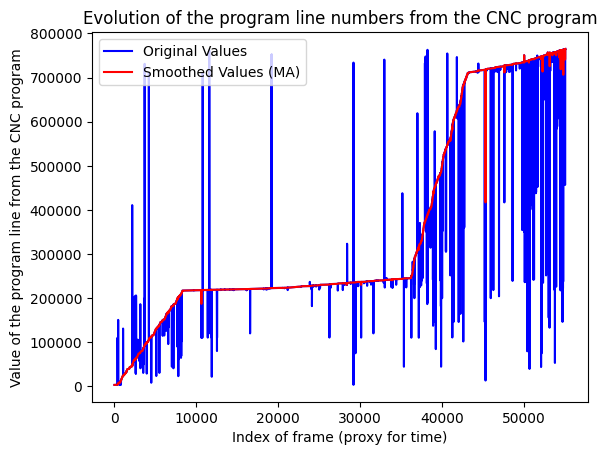

In [8]:
import numpy as np
import matplotlib.pyplot  as plt

x=np.arange(len(myIndicesPd))
plt.plot(x, myIndicesPd, label="Original Values", color='blue')
plt.plot(x, myMovAvIndices, label="Smoothed Values (MA)", color='red')
plt.xlabel('Index of frame (proxy for time)')
plt.ylabel('Value of the program line from the CNC program')
plt.title('Evolution of the program line numbers from the CNC program')
plt.legend(loc='upper left')
plt.show()

In [9]:
del myMovAvIndices, x, i, size, mean, std, winSize, windowLst

## Smoothing with "robust" method
The robust method rely on the median and the median absolute deviation (MAD) to detect outliers. The method is based on the modified Z-score and the threshold is set to 3. Results show no noticable jumps. The method seems to work well.

In [10]:
from tqdm import tqdm
import numpy as np

def detect_and_remove_local_outliers(data, window_size=10, threshold=3):
    """
    Detect and replace local outliers in a time series with a progress bar.
   
    Args:
        data: List of original time series values.
        window_size: The size of the local segment for detecting outliers.
        threshold: Threshold for detecting outliers (in terms of Z-score).
   
    Returns:
        List of cleaned values with outliers replaced.
    """
    cleaned_data = data.copy()
   
    for i in tqdm(range(len(data)), desc="Processing data"):
        # Define local window boundaries
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
       
        # Extract local window
        localWindow = data[start:end]
       
        # Compute median and MAD (Median Absolute Deviation)
        locMed = np.median(localWindow)
        mad = np.median(np.abs(localWindow - locMed))
        modZScore = 0.6745 * (data[i] - locMed) / (mad if mad > 0 else 1)
       
        # Detect and replace outlier
        if np.abs(modZScore) > threshold:
            cleaned_data[i] = cleaned_data[i-1]  # Replace with previous value
   
    return cleaned_data

# Example usage
myCleanedIndices = detect_and_remove_local_outliers(myIndicesPd, window_size=50, threshold=3)

print("Original Values:", myIndicesPd)
print("Cleaned Values:", myCleanedIndices)

Processing data: 100%|██████████| 55117/55117 [00:28<00:00, 1905.11it/s]

Original Values: 0          3380
1          3380
2          3380
3          3380
4          3380
          ...  
55112    765000
55113    765000
55114    765000
55115    765000
55116    765000
Length: 55117, dtype: int64
Cleaned Values: 0          3380
1          3380
2          3380
3          3380
4          3380
          ...  
55112    765000
55113    765000
55114    765000
55115    765000
55116    765000
Length: 55117, dtype: int64


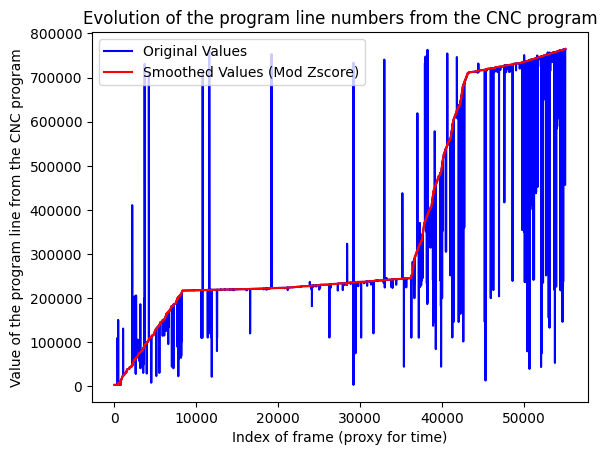

In [11]:
import numpy as np
import matplotlib.pyplot  as plt

x=np.arange(len(myIndicesPd))
plt.plot(x, myIndicesPd, label="Original Values", color='blue')
plt.plot(x, myCleanedIndices, label="Smoothed Values (Mod Zscore)", color='red')
plt.xlabel('Index of frame (proxy for time)')
plt.ylabel('Value of the program line from the CNC program')
plt.title('Evolution of the program line numbers from the CNC program')
plt.legend(loc='upper left')
plt.show()

In [12]:
import numpy as np
myDiff=pd.Series()
size=0

for i in range(1,len(myCleanedIndices)):
    if myCleanedIndices[i]<myCleanedIndices[i-1]:
        myDiff[i]=myCleanedIndices[i]-myCleanedIndices[i-1]
        size+=1
    else:
        myDiff[i]=0
        
print(size)

del size, i

149


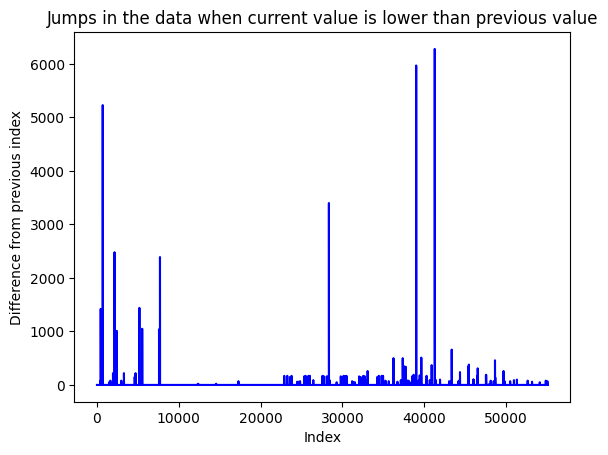

In [13]:
import matplotlib.pyplot  as plt


x=np.arange(len(myDiff))
myDiff=myDiff.abs()
plt.plot(x, myDiff, label="Differences From Previous Indices", color='blue')
plt.title("Jumps in the data when current value is lower than previous value")
plt.xlabel('Index')
plt.ylabel('Difference from previous index')
plt.show()
del x, myDiff

## Data seems cleaner but still some jumps. Let's try to clean it further
From previous section, we know that there is 149 jumps backward. This seems that our data can be further cleaned / improved.

We know that our program is executed sequentially and that from one frame to the next, the program line number should not decrease. We will use this information to clean the data further.

In [14]:
def data_isCleaned(data):
    idxLst=[]
    size=0
    prevData=data[0]
    for i in range(len(data)):
        if i>0:
            if data[i] < prevData:
                idxLst.append(i)
                size+=1
        prevData=data[i] 
    return size<=0, size, np.array(idxLst)

def cleaning_data(data):
    ascendingCleanedData=data.copy()
    isCleaned, nbJumps, idx=data_isCleaned(data)
    print(isCleaned, nbJumps)
    it=0
    while nbJumps>9:
        it+=1
        for i in idx:
            ascendingCleanedData[i]=ascendingCleanedData[i-1]
        isCleaned, nbJumps, idx=data_isCleaned(ascendingCleanedData)
        print(isCleaned, nbJumps, it)
    return ascendingCleanedData, idx

myAscendingCleanedData, myJumpsIndices=cleaning_data(myCleanedIndices)

False 149
False 79 1
False 56 2
False 49 3
False 46 4
False 42 5
False 40 6
False 40 7
False 39 8
False 37 9
False 37 10
False 37 11
False 37 12
False 37 13
False 36 14
False 36 15
False 36 16
False 36 17
False 36 18
False 36 19
False 36 20
False 35 21
False 35 22
False 35 23
False 35 24
False 35 25
False 35 26
False 35 27
False 35 28
False 35 29
False 35 30
False 35 31
False 35 32
False 35 33
False 34 34
False 34 35
False 34 36
False 34 37
False 34 38
False 34 39
False 34 40
False 34 41
False 34 42
False 32 43
False 32 44
False 32 45
False 32 46
False 32 47
False 32 48
False 32 49
False 32 50
False 32 51
False 32 52
False 32 53
False 32 54
False 32 55
False 32 56
False 32 57
False 32 58
False 32 59
False 32 60
False 32 61
False 32 62
False 32 63
False 32 64
False 32 65
False 32 66
False 32 67
False 32 68
False 32 69
False 32 70
False 32 71
False 32 72
False 32 73
False 32 74
False 31 75
False 31 76
False 31 77
False 30 78
False 29 79
False 27 80
False 27 81
False 25 82
False 23 83
Fal

In [15]:
print("Indices with remaining jumps: ", myJumpsIndices)
del myJumpsIndices

Indices with remaining jumps:  [23439 27741 32733]


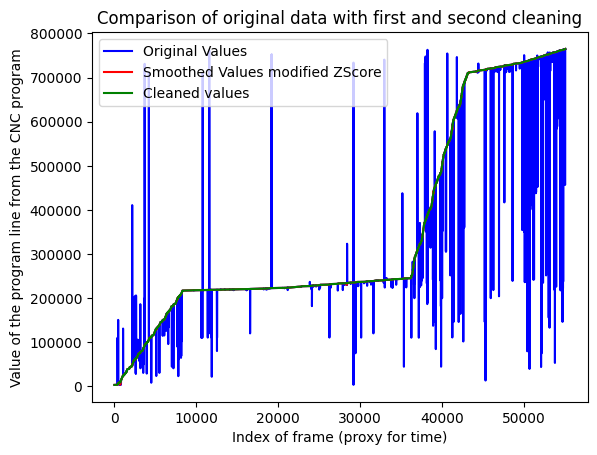

In [24]:
x=np.arange(len(myIndicesPd))

#plt.figure(figsize=(8,12))
#plt.subplot(2,1,1)
plt.plot(x, myIndicesPd, label="Original Values", color='blue')
plt.plot(x, myCleanedIndices, label="Smoothed Values modified ZScore", color='red')
plt.plot(x, myAscendingCleanedData, label="Cleaned values", color='green')
plt.title("Comparison of original data with first and second cleaning")
plt.xlabel('Index of frame (proxy for time)')
plt.ylabel('Value of the program line from the CNC program')
plt.legend(loc='upper left')

''' useful during the cleaning process, not anymore 
plt.subplot(2,1,2)
plt.plot(x, myAscendingCleanedData-myCleanedIndices, label="Smoothed Values", color='red')
plt.title("Jumps in the data when current value is lower than previous value")
plt.xlabel('Index')
plt.ylabel('Difference between values of first and second cleaning')
plt.show()
'''
del x

In [20]:
myDiff=pd.Series()
size=0

for i in range(1,len(myAscendingCleanedData)):
    if myAscendingCleanedData[i]<myAscendingCleanedData[i-1]:
        myDiff[i]=myAscendingCleanedData[i]-myAscendingCleanedData[i-1]
        size+=1
    else:
        myDiff[i]=0
        
print(size)

del size, i

3


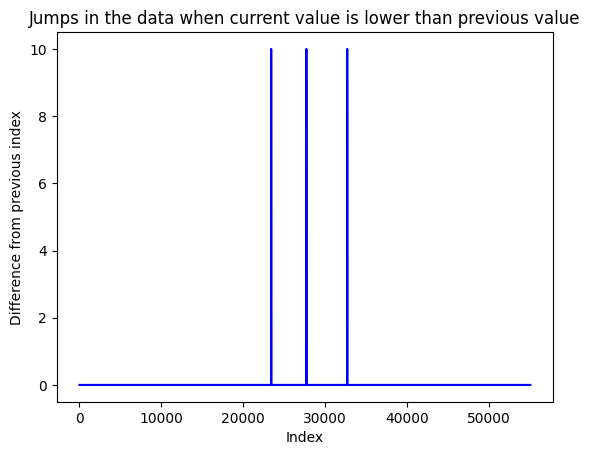

In [21]:


x=np.arange(len(myDiff))
myDiff=myDiff.abs()
plt.plot(x, myDiff, label="Differences From Previous Indices", color='blue')
plt.title("Jumps in the data when current value is lower than previous value")
plt.xlabel('Index')
plt.ylabel('Difference from previous index')
plt.show()
del x, myDiff

# Modifying the Original Dataframe with the new cleaned values

In [26]:
#Import the original Dataframe containing the program lines
OriginalProgramDf=pd.read_parquet('F:/Data_BachelorHES/3.Video_CNC/10.ProcessingResults/OriginalProgramLines.parquet', engine='pyarrow')


In [31]:
# Liste pour stocker les lignes correspondant à chaque Ascending
def newSequence(newSequenceDf, original_program_df):
    selected_rows = []

    for op_nb in newSequenceDf:
        # Filtrer les lignes correspondantes dans myCncProgDf
        matches = original_program_df[original_program_df['Op_nb'] == op_nb]
        # Ajouter les lignes correspondantes à la liste
        selected_rows.append(matches)
    return selected_rows
    
# Concaténer toutes les lignes sélectionnées en un nouveau DataFrame
newOpSeq = pd.concat(newSequence(myAscendingCleanedData, OriginalProgramDf)).reset_index(drop=True)


In [32]:
DfLabelledTimeSeries['Label_Program_Line']=newOpSeq['Op_Name'].values
DfLabelledTimeSeries['Label_Op_Name']=newOpSeq['BigOp_Name'].values
DfLabelledTimeSeries['Label_Tool_Name']=newOpSeq['Tool_Name'].values
DfLabelledTimeSeries['Op_Nb'] = newOpSeq['Op_nb'].values

In [33]:
#Reorganisaton des colonnes pour avoir le numéro d'opération avant le nom de l'opération
cols = DfLabelledTimeSeries.columns.tolist()
idx = cols.index('Label_Program_Line')
new_cols = cols[:idx] + ['Op_Nb'] + cols[idx:-1]
DfLabelledTimeSeries = DfLabelledTimeSeries[new_cols]

## Save the Cleaned Dataframe to a parquet file

In [34]:
import pyarrow as pa 
import pyarrow.parquet as pq

myResTable=pa.Table.from_pandas(DfLabelledTimeSeries)
pq.write_table(myResTable, 'F:/Data_BachelorHES/5.Dataset_preparation/CNC_Labelled_Data_Cleaned.parquet')
del myResTable